# AlexNet : From Scratch vs. Transfer Learning

Its name comes from one of the leading authors of the AlexNet paper – Alex Krizhevsky. It won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 with a top-5 error rate of 15.3% (beating the runner up which had a top-5 error rate of 26.2%).

The most important features of the AlexNet paper are:

- As the model had to train 60 million parameters (which is quite a lot), it was prone to overfitting. According to the paper, the usage of Dropout and Data Augmentation significantly helped in reducing overfitting. The first and second fully connected layers in the architecture thus used a dropout of 0.5 for the purpose. Artificially increasing the number of images through data augmentation helped in the expansion of the dataset dynamically during runtime, which helped the model generalize better.

- Another distinct factor was using the ReLU activation function instead of tanh or sigmoid, which resulted in faster training times (a decrease in training time by 6 times). Deep Learning Networks usually employ ReLU non-linearity to achieve faster training times as the others start saturating when they hit higher activation values.

## The Architecture
The architecture consists of 5 Convolutional layers, with the 1st, 2nd and 5th having Max-Pooling layers for proper feature extraction. The Max-Pooling layers are overlapped having strides of 2 with filter size 3×3. This resulted in decreasing the top-1 and top-5 error rates by 0.4% and 0.3% respectively in comparison to non-overlapped Max-Pooling layers. They are followed by 2 fully-connected layers (each with dropout) and a softmax layer at the end for predictions.

The figure below shows the architecture of AlexNet with all the layers defined.

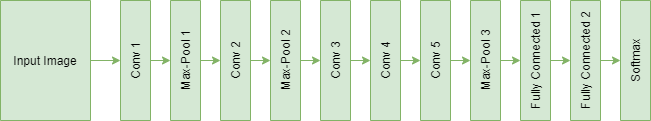

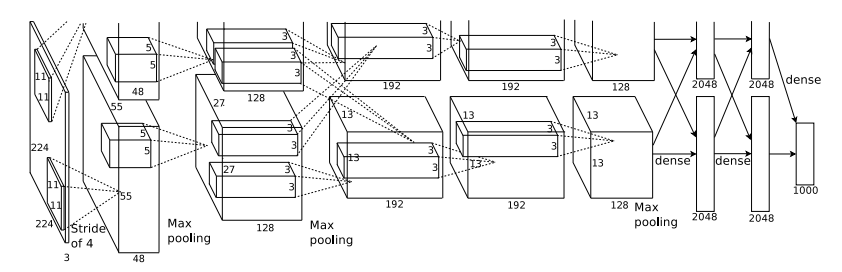

## Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import random

from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import torch.optim as optim

In [ ]:
dir = "/content/drive/MyDrive/CENG506-TermProject/dataset" # Dataset dizini ile değiştirin.
os.listdir(dir)

['.DS_Store', 'leopard', 'elephant', 'bear', 'zebra']

In [ ]:
animal_classes = [animal for animal in os.listdir(dir)[1:]]
animal_classes

['leopard', 'elephant', 'bear', 'zebra']

In [ ]:
#From directory, we get all images to list.

data = []
labels = []

for class_name in os.listdir(dir)[1:]:
    class_folder = os.path.join(dir, class_name)
    if os.path.isdir(class_folder):

        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)

            try:
                image = cv2.imread(image_path)
                data.append(image)
                labels.append(class_name)
            except Exception as e:
                print(f"Error reading image: {image_path}")
                print(f"Exception: {e}")

In [ ]:
#After. getting all information, we create pandas df from them.
dataset = {"pixels":data,"classes":labels}
df = pd.DataFrame(dataset)

In [ ]:
print("Random Images shape: " + str(df["pixels"][22].shape))
print("Classes shape: " + str(df["classes"].shape))
print("Data shape: " + str(df.shape))

Random Images shape: (420, 315, 3)
Classes shape: (1400,)
Data shape: (1400, 2)


Some random samples from dataset:


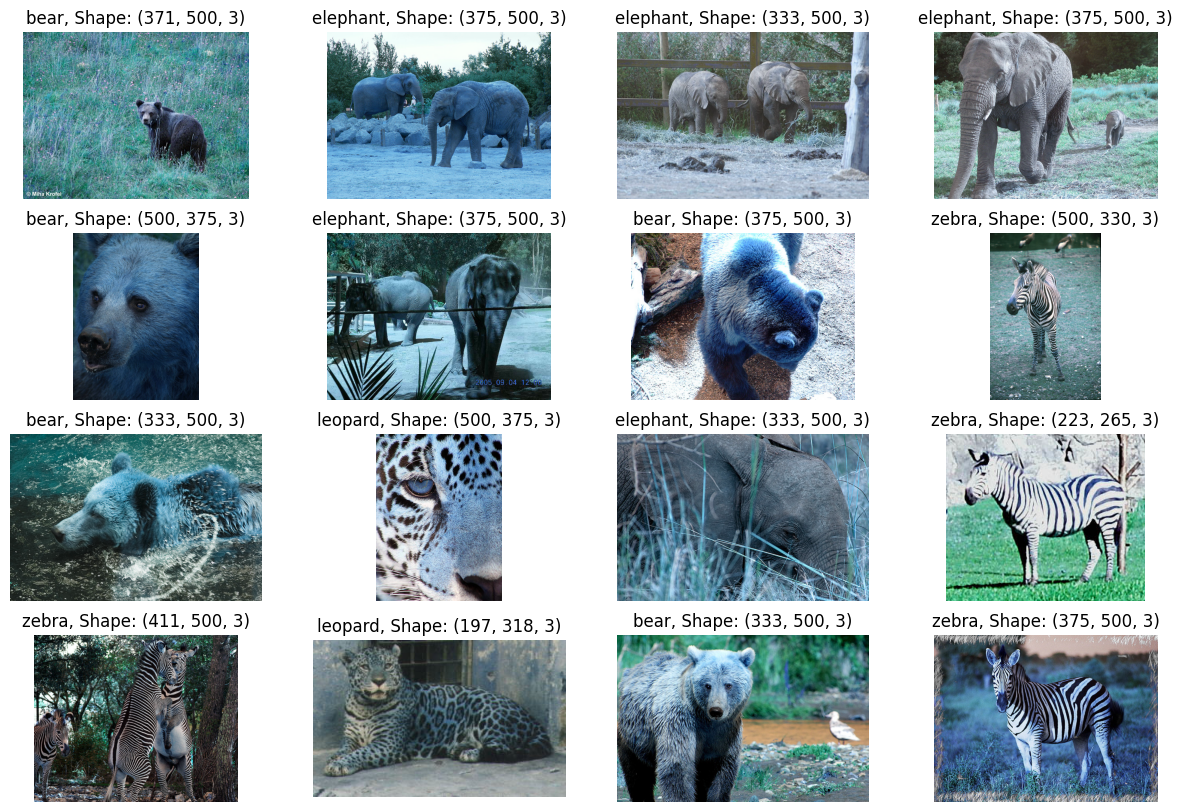

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
print("Some random samples from dataset:")
for i, ax in enumerate(axes.flat):
  random_sample = random.randint(0,1400) #There are 1400 images on this dataset. We choose random image from it.
  ax.axis("off")
  ax.imshow(df["pixels"][random_sample], cmap='gray')
  ax.set_title(df["classes"][random_sample]+", Shape: "+str(df["pixels"][random_sample].shape))

In [ ]:
# Here, we fixed all images sizes to (227,227,3). Because Alexnet takes input as this size.
new_size = (227,227)
for i in range(len(df)):
  resized_img = cv2.resize(df["pixels"].loc[i],new_size)
  df["pixels"].loc[i] = resized_img

Some random samples from dataset (After resize):


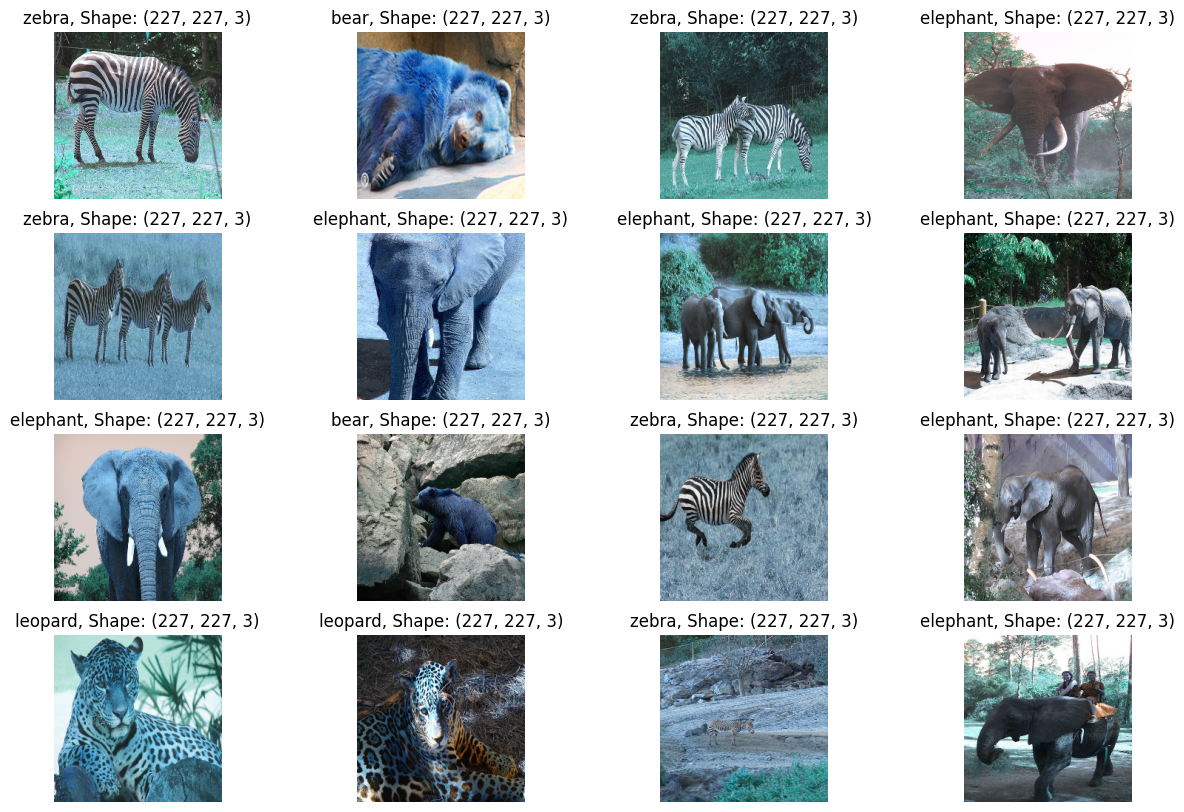

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
print("Some random samples from dataset (After resize):")
for i, ax in enumerate(axes.flat):
  random_sample = random.randint(0,1400)
  ax.axis("off")
  ax.imshow(df["pixels"][random_sample], cmap='gray')
  ax.set_title(df["classes"][random_sample]+", Shape: "+str(df["pixels"][random_sample].shape))

In [ ]:
print(df["pixels"][0]) #As you can see, we have to normalize these pixel values.

[[[ 35  48  34]
  [ 33  47  39]
  [ 44  48  45]
  ...
  [ 92 119  70]
  [101 116  81]
  [110 123  79]]

 [[ 25  48  41]
  [ 18  35  45]
  [ 45  70  64]
  ...
  [ 96 119  68]
  [113 111  78]
  [107 120  83]]

 [[ 22  40  38]
  [ 28  27  40]
  [ 48  72  44]
  ...
  [ 89 117  65]
  [ 97 117  83]
  [102 124  79]]

 ...

 [[174 183 194]
  [190 197 203]
  [218 216 218]
  ...
  [135 135 148]
  [140 143 151]
  [145 136 140]]

 [[154 147 167]
  [165 171 194]
  [165 163 200]
  ...
  [135 142 141]
  [ 98 113 125]
  [ 96 113  99]]

 [[136 136 152]
  [139 140 159]
  [150 145 171]
  ...
  [ 81 102  96]
  [ 83 112  89]
  [100 117 108]]]


In [ ]:
norm_pixels = np.array(df['pixels'].tolist())

#Normalizing the pixel values between 0 and 1
norm_pixels = norm_pixels / 255.0

In [ ]:
#Making the categorical info to numeric one.
label_encoder = LabelEncoder()

animals = df["classes"]

encoded_labels = label_encoder.fit_transform(animals)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mapping)

{'bear': 0, 'elephant': 1, 'leopard': 2, 'zebra': 3}


In [ ]:
#Purpose of this step, later We can address which animal corresponds which number etc.

classes_encoded = pd.get_dummies(df['classes'])
classes_encoded

label_mapping_one_hot = dict(zip(df['classes'], classes_encoded.values.tolist()))

print(label_mapping_one_hot)

{'leopard': [0, 0, 1, 0], 'elephant': [0, 1, 0, 0], 'bear': [1, 0, 0, 0], 'zebra': [0, 0, 0, 1]}


- At next cell, our y values will be 0,1,2,3 respectly. I did one hot encode mapping to remember which animal belongs to which one hot encode.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_pixels, encoded_labels, test_size=0.2,stratify=encoded_labels, random_state=42)

#Stratify makes splitting equally based on labels.

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1120, 227, 227, 3)
(280, 227, 227, 3)
(1120,)
(280,)


Some random samples from Train dataset:


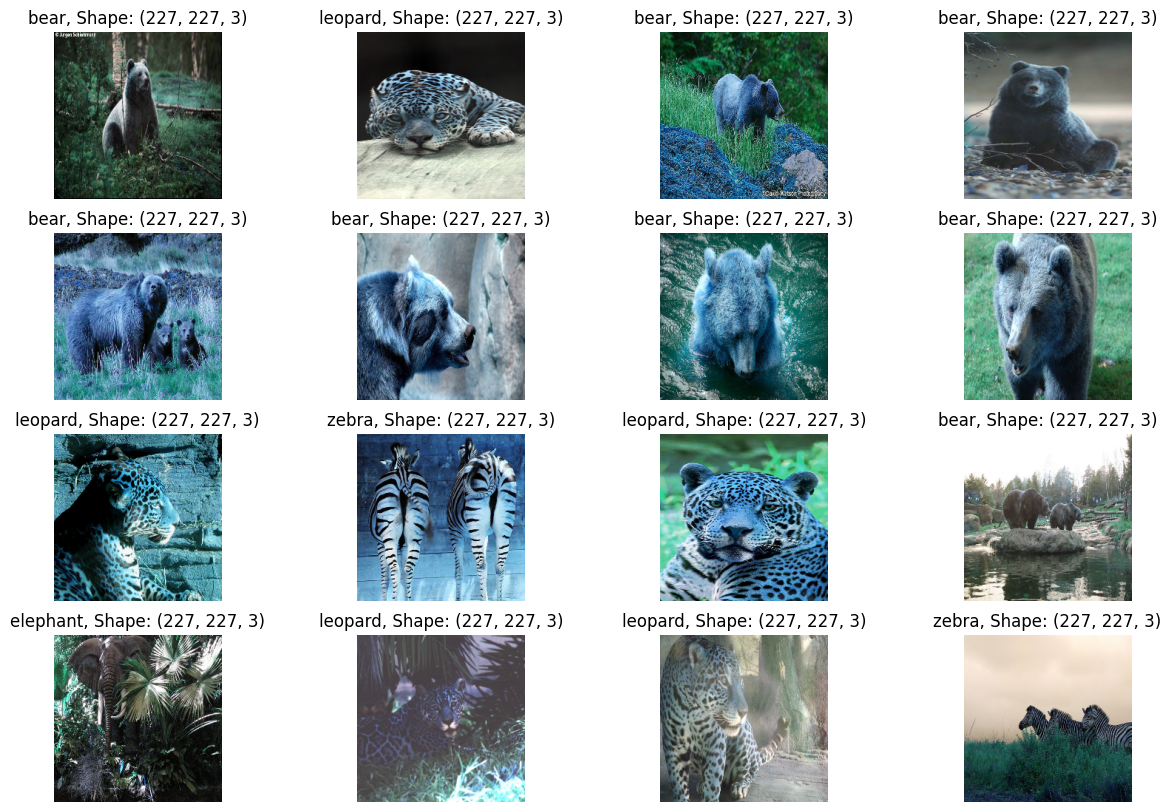

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
print("Some random samples from Train dataset:")
for i, ax in enumerate(axes.flat):
  random_sample = random.randint(0,1120) # 1120 because there are 1120 images on train set.
  ax.axis("off")
  ax.imshow(X_train[random_sample], cmap='gray')
  key = next((k for k, v in label_mapping.items() if v == y_train[random_sample]), None) #wesave our values(encoded labels) and their keys(animal's names) to label_mapping dict. We reach key values to according encoded label.
  ax.set_title(key+", Shape: "+str(X_train[random_sample].shape))

Some random samples from Test dataset:


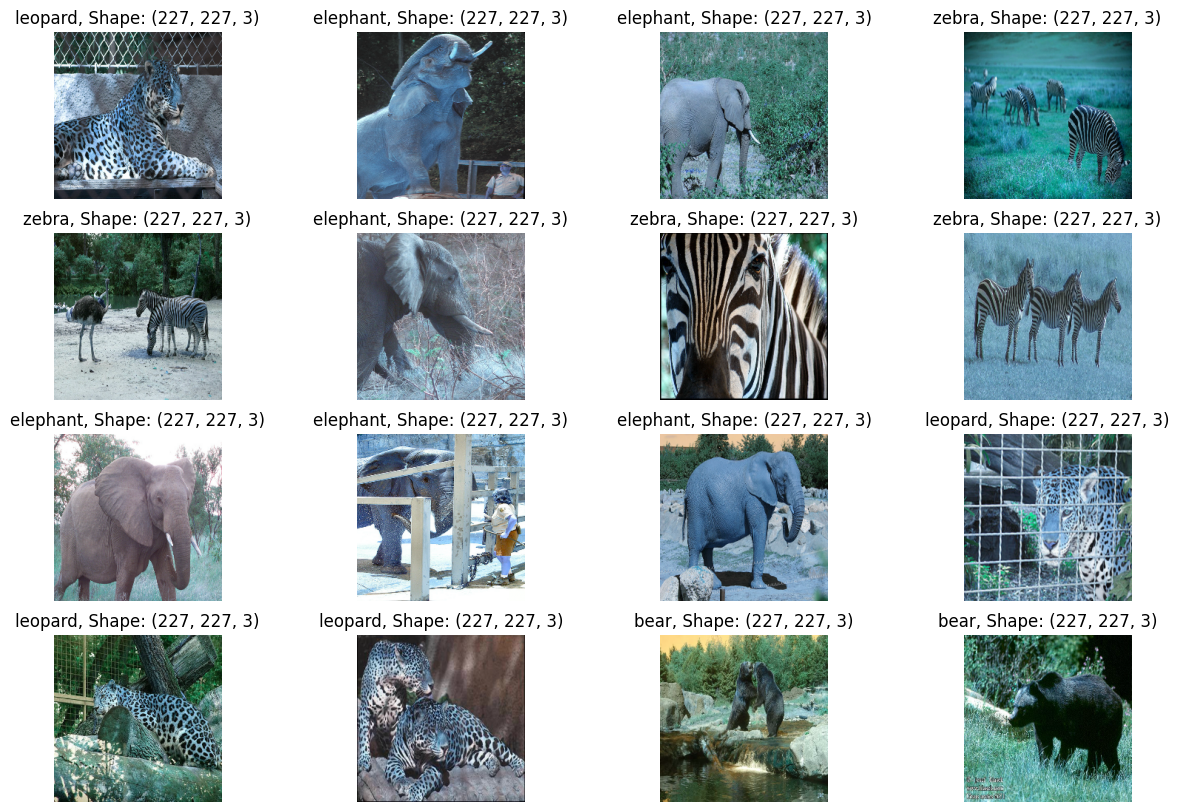

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(15,10))
print("Some random samples from Test dataset:")
for i, ax in enumerate(axes.flat):
  random_sample = random.randint(0,280) #280 because there are 280 images on test dataset
  ax.axis("off")
  ax.imshow(X_test[random_sample], cmap='gray')
  key = next((k for k, v in label_mapping.items() if v == y_test[random_sample]), None)
  ax.set_title(key+", Shape: "+str(X_test[random_sample].shape))

Text(0.5, 1.0, 'Train Set Class Counts(Pie Chart)')

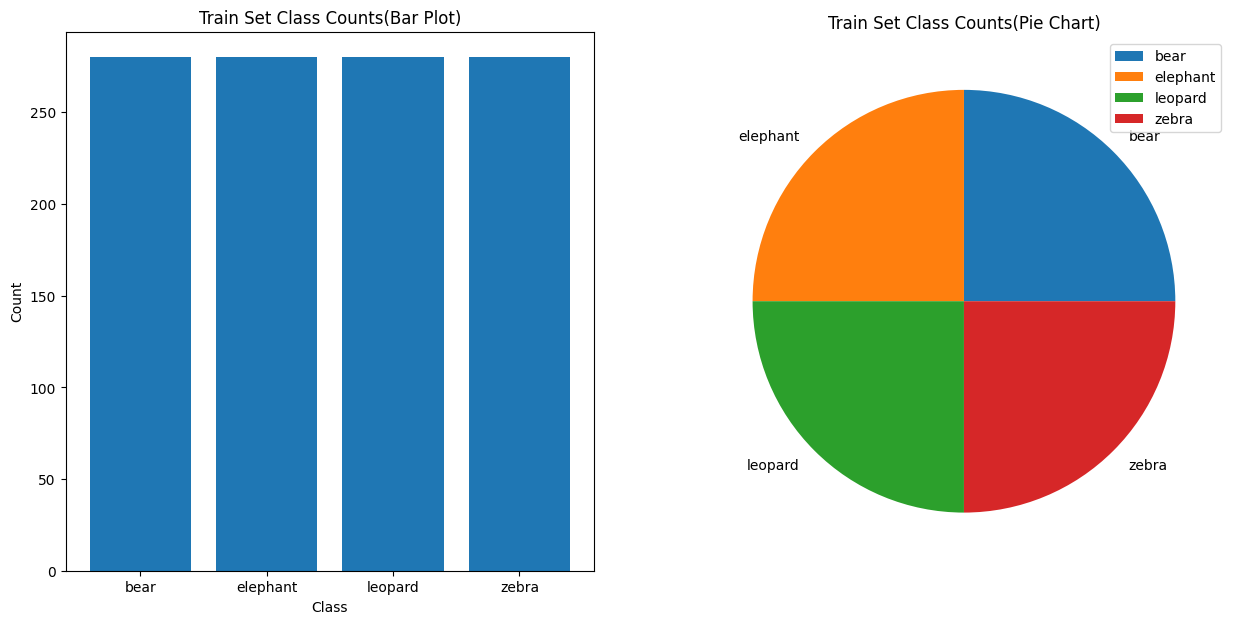

In [ ]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

class_values = label_mapping.keys()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.bar(class_values, class_counts)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Train Set Class Counts(Bar Plot)')


ax2.pie(class_counts, labels = class_values)
ax2.legend()
ax2.set_title("Train Set Class Counts(Pie Chart)")


- As you can see, they splitted equally. Because of stratify parameter at train_test_split stage.

Text(0.5, 1.0, 'Test Set Class Counts(Pie Chart)')

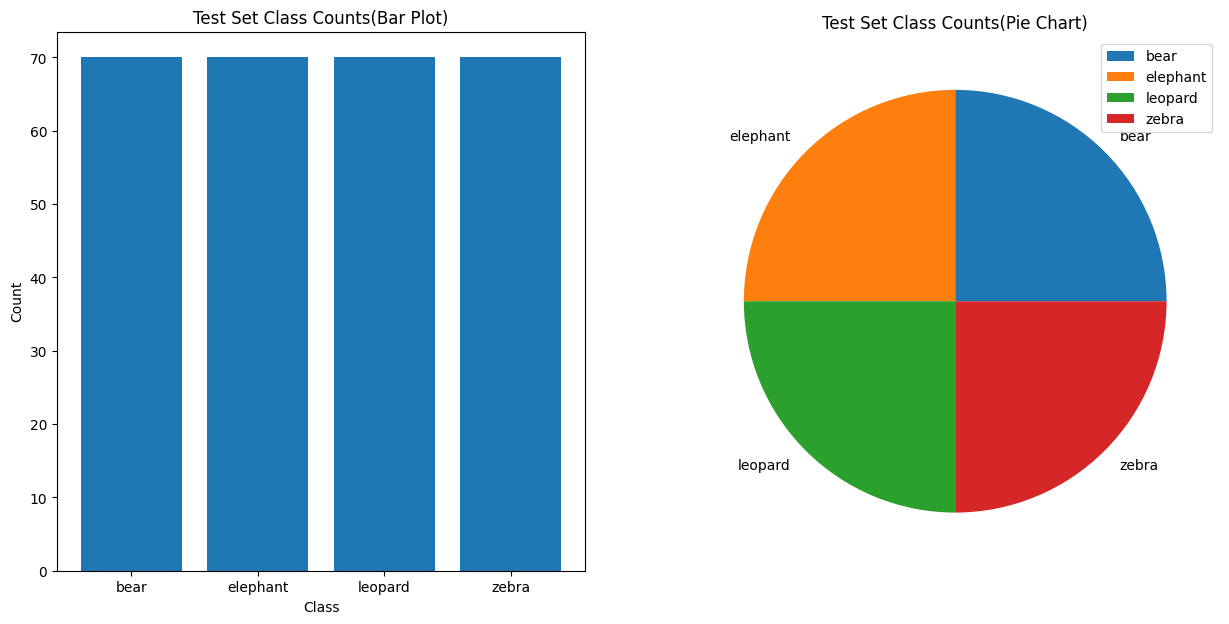

In [ ]:
unique_classes, class_counts = np.unique(y_test, return_counts=True)

class_values = label_mapping.keys()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.bar(class_values, class_counts)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Test Set Class Counts(Bar Plot)')


ax2.pie(class_counts, labels = class_values)
ax2.legend()
ax2.set_title("Test Set Class Counts(Pie Chart)")


## AlexNet: From Scratch

In [ ]:
model = Sequential()

#Layer1
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu',input_shape=(227,227,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(BatchNormalization())

#Layer2
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(BatchNormalization())

#Layer3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

#Layer4
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

#Layer5
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1) ,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#FC6
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))

#FC7
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))

#FC8
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                        

In [ ]:
label_mapping

{'bear': 0, 'elephant': 1, 'leopard': 2, 'zebra': 3}

In [ ]:
label_mapping_one_hot

{'leopard': [0, 0, 1, 0],
 'elephant': [0, 1, 0, 0],
 'bear': [1, 0, 0, 0],
 'zebra': [0, 0, 0, 1]}

- As you can see, this 2 mapping stores valuable information. First, I will reverse the "label_mapping" to make numeratic info to value and animal classes become keys.
- Then, I can reach which animal class equals to which one hot encode. Because till now, our y labels are 0,1,2,3. We will change them in this step.

In [ ]:
#Encoding step.. NOW, we can user one hot encoding that we did previous steps..
reverse_label_mapping_encoder = {value: key for key, value in label_mapping.items()}

reverse_label_mapping_encoder

{0: 'bear', 1: 'elephant', 2: 'leopard', 3: 'zebra'}

In [ ]:
y_train_encoded = [label_mapping_one_hot[reverse_label_mapping_encoder[label]] for label in y_train]

y_train_encoded = np.stack(y_train_encoded)
y_train_encoded[:10]

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [ ]:
history = model.fit(X_train,y_train_encoded, batch_size=64, epochs=30, verbose=1)

Epoch 1/30
18/18 [==============================] - 15s 75ms/step - loss: 1.9640 - accuracy: 0.3170
Epoch 2/30
18/18 [==============================] - 1s 46ms/step - loss: 1.0883 - accuracy: 0.4830
Epoch 3/30
18/18 [==============================] - 1s 46ms/step - loss: 0.9250 - accuracy: 0.5679
Epoch 4/30
18/18 [==============================] - 1s 58ms/step - loss: 0.8763 - accuracy: 0.5955
Epoch 5/30
18/18 [==============================] - 1s 59ms/step - loss: 0.7953 - accuracy: 0.6518
Epoch 6/30
18/18 [==============================] - 1s 63ms/step - loss: 0.6905 - accuracy: 0.7250
Epoch 7/30
18/18 [==============================] - 1s 54ms/step - loss: 0.6139 - accuracy: 0.7536
Epoch 8/30
18/18 [==============================] - 1s 46ms/step - loss: 0.6225 - accuracy: 0.7420
Epoch 9/30
18/18 [==============================] - 1s 46ms/step - loss: 0.5004 - accuracy: 0.7955
Epoch 10/30
18/18 [==============================] - 1s 66ms/step - loss: 0.4928 - accuracy: 0.8045
Epoch 11

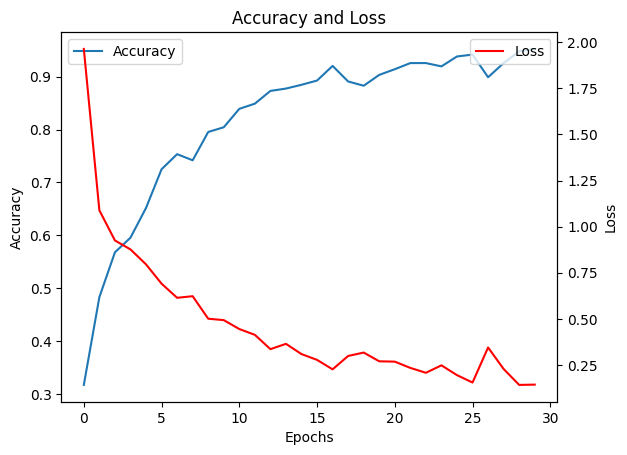

In [ ]:
plt.plot(model.history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and Loss')
plt.legend()

plt.twinx()
plt.plot(model.history.history['loss'], color='r', label='Loss')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#To evaluate our model on test data, we have to encode our y. Same as before(on y_train)
y_test_encoded = [label_mapping_one_hot[reverse_label_mapping_encoder[label]] for label in y_test]

y_test_encoded = np.stack(y_test_encoded)
y_test_encoded[:10]

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print("Model loss on test set: "+str(test_loss))
print("Model accuracy on test set: "+str(test_accuracy))

9/9 [==============================] - 1s 50ms/step - loss: 1.5296 - accuracy: 0.6571
Model loss on test set: 1.5296369791030884
Model accuracy on test set: 0.6571428775787354


In [ ]:
fig = go.Figure(go.Indicator(
  mode = "gauge+number",
  value = test_accuracy*100,
  domain = {'x': [0, 1], 'y': [0, 1]},
  title = {'text': "Test dataset Accuracy"},
  gauge={'axis': {'range': [0, 100]},
        'bar': {'color': "darkblue"},
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': test_accuracy*100
        },
        'steps': [
            {'range': [0, 50], 'color': "lightgray"},
            {'range': [50, 70], 'color': "gray"},
            {'range': [70, 100], 'color': "lightgray"}
        ]}
    ))

fig.show()

- As you can see, accuracy is pretty low on test data.

## AlexNet: Transfer Learning

In [ ]:
#Convertin training data to TensorDataset
x_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train_encoded)

train_dataset = TensorDataset(torch.tensor(x_tensor), torch.tensor(y_tensor))

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


<ipython-input-38-15172925b2c7>:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
#Creating alexnet pretrained model
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:10<00:00, 24.1MB/s]


In [ ]:
for param in alexnet.parameters():
    param.requires_grad = False

In [ ]:
#Replacing classifier with our 4 class
num_classes = 4
alexnet.classifier = nn.Sequential(
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, num_classes)
)


In [ ]:
#Training...
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

alexnet = alexnet.to(torch.float32)

#Saving our accuracy and loss eat each epoch
accuracy_log = []
loss_log = []

for epoch in range(10):
  total_loss = 0.0
  correct_predictions = 0
  total_predictions = 0

  for images, labels in train_dataloader:
    images = images.to(torch.float32)
    inputs = images.permute(0, 3, 1, 2)
    optimizer.zero_grad()
    outputs = alexnet(inputs)
    labels = labels.float()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #For accuracy calc.
    _, predicted_indices = torch.max(outputs, 1)
    true_indices = torch.argmax(labels, dim=1)
    total_predictions += labels.size(0)
    correct_predictions += (predicted_indices == true_indices).sum().item()
    #loss calc.
    total_loss += loss.item()
  #metrics calc.
  accuracy = correct_predictions / total_predictions
  average_loss = total_loss / len(train_dataloader)

  accuracy_log.append(accuracy)
  loss_log.append(average_loss)
  print(f"Epoch {epoch+1}: Average Loss = {average_loss:.4f}, Accuracy = {accuracy:.4f}")


Epoch 1: Average Loss = 1.2210, Accuracy = 0.5804
Epoch 2: Average Loss = 0.6993, Accuracy = 0.9009
Epoch 3: Average Loss = 0.3771, Accuracy = 0.9330
Epoch 4: Average Loss = 0.2390, Accuracy = 0.9509
Epoch 5: Average Loss = 0.1773, Accuracy = 0.9643
Epoch 6: Average Loss = 0.1453, Accuracy = 0.9696
Epoch 7: Average Loss = 0.1236, Accuracy = 0.9777
Epoch 8: Average Loss = 0.1014, Accuracy = 0.9804
Epoch 9: Average Loss = 0.0876, Accuracy = 0.9821
Epoch 10: Average Loss = 0.0751, Accuracy = 0.9875


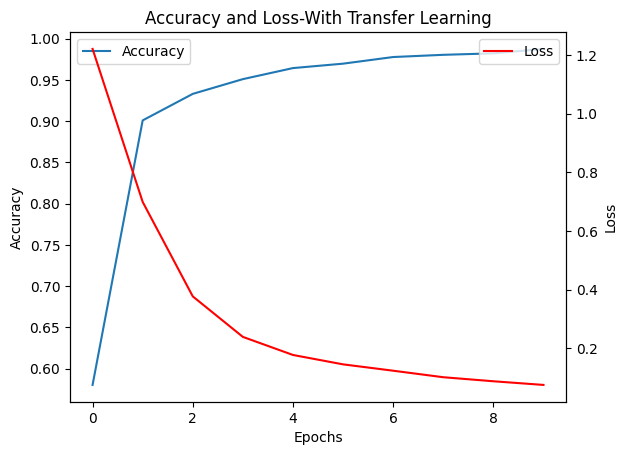

In [ ]:
# Plotting accuracy
plt.plot(accuracy_log, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and Loss-With Transfer Learning')
plt.legend()

plt.twinx()
plt.plot(loss_log, color='r', label='Loss')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# see values on test dataset

x_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test_encoded)

test_dataset = TensorDataset(torch.tensor(x_test_tensor), torch.tensor(y_test_tensor))

batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-45-e17bbf8de94a>:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
alexnet.eval() #evaluate mode..

total_loss = 0.0
correct_predictions = 0
total_predictions = 0

for images, labels in test_dataloader:
  images = images.to(torch.float32)
  inputs = images.permute(0, 3, 1, 2)
  outputs = alexnet(inputs)
  labels = labels.float()
  loss = criterion(outputs, labels)

  _, predicted_indices = torch.max(outputs, 1)
  true_indices = torch.argmax(labels, dim=1)
  total_predictions += labels.size(0)
  correct_predictions += (predicted_indices == true_indices).sum().item()
  total_loss += loss.item()

accuracy = correct_predictions / total_predictions
average_loss = total_loss / len(test_dataloader)

print(f"Test: Average Loss = {average_loss:.4f}, Accuracy = {accuracy:.4f}")


Test: Average Loss = 0.1608, Accuracy = 0.9393


In [ ]:
fig = go.Figure(go.Indicator(
  mode = "gauge+number",
  value = accuracy*100,
  domain = {'x': [0, 1], 'y': [0, 1]},
  title = {'text': "Test dataset Accuracy-with Transfer Learning"},
  gauge={'axis': {'range': [0, 100]},
        'bar': {'color': "darkgreen"},
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': accuracy*100
        },
        'steps': [
            {'range': [0, 100], 'color': "lightgray"}
        ]}
    ))

fig.show()

- As you can see, perfect accuracy on test dataset with transfer learning.

---------------------------------------------------------------------------

## Results

- As you can see, Transfer learning is highly successful compared to training a model from scratch. (I was actually shocked by such a significant difference.) And it achieved this success with fewer epochs. That's really impressive.
- Alexnet from scratch is also good. But as you can see on accuracy and loss diagram, it fluctuates. And it took 30 epochs to reach that accuracy result.
- If we compare Accuracy results on test dataset, **Transfer Learning** is a way ahead.
- Overall, Transfer Learning is the best solution.

# One of best Practices for Alexnet from scratch: Regularization
Regularization is a technique used to prevent overfitting and improve the generalization ability of machine learning models. It adds a penalty term to the loss function, encouraging the model to learn simpler representations and reduce the impact of noisy or irrelevant features. Regularization can be particularly beneficial when training complex models like AlexNet. There are two commonly used regularization techniques:

### L1 and L2 Regularization (Weight Decay):
- L1 regularization, also known as Lasso regularization, adds the absolute value of the model's weights to the loss function. It encourages the model to reduce the magnitude of less important weights, effectively performing feature selection.

- L2 regularization, also known as Ridge regularization, adds the squared magnitude of the model's weights to the loss function. It encourages the model to distribute the weights more evenly across all features, preventing large weights from dominating the learning process.

In practice, L2 regularization is more commonly used due to its smoother gradient and ability to handle correlated features. The regularization term is controlled by a hyperparameter called the regularization strength or lambda (λ). Higher values of λ result in more regularization, leading to simpler models with smaller weights.

In [ ]:
from keras.regularizers import l2

model_regularized = Sequential()

#Layer1
model_regularized.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu',input_shape=(227,227,3)))
model_regularized.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_regularized.add(BatchNormalization())

#Layer2
model_regularized.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model_regularized.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model_regularized.add(BatchNormalization())

#Layer3
model_regularized.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

#Layer4
model_regularized.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

#Layer5
model_regularized.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1) ,padding='same', activation='relu'))
model_regularized.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

#FC6
model_regularized.add(Flatten())
model_regularized.add(Dense(units=4096, activation='relu', kernel_regularizer = l2(0.01)))
model_regularized.add(Dropout(0.5))

#FC7
model_regularized.add(Dense(units=4096, activation='relu', kernel_regularizer = l2(0.01)))
model_regularized.add(Dropout(0.5))

#FC8
model_regularized.add(Dense(units=4, activation='softmax'))

model_regularized.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_regularized.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 27, 27, 96)       384       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 256)       221440    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                      

In [ ]:
history_regularized = model_regularized.fit(X_train, y_train_encoded, batch_size=64, epochs=30, verbose=1)

Epoch 1/30
18/18 [==============================] - 6s 55ms/step - loss: 36.4787 - accuracy: 0.3018
Epoch 2/30
18/18 [==============================] - 1s 48ms/step - loss: 10.9074 - accuracy: 0.5437
Epoch 3/30
18/18 [==============================] - 1s 49ms/step - loss: 5.0888 - accuracy: 0.6384
Epoch 4/30
18/18 [==============================] - 1s 48ms/step - loss: 2.8862 - accuracy: 0.7250
Epoch 5/30
18/18 [==============================] - 1s 48ms/step - loss: 1.9040 - accuracy: 0.7696
Epoch 6/30
18/18 [==============================] - 1s 49ms/step - loss: 1.3520 - accuracy: 0.7991
Epoch 7/30
18/18 [==============================] - 1s 51ms/step - loss: 0.9860 - accuracy: 0.8402
Epoch 8/30
18/18 [==============================] - 1s 62ms/step - loss: 0.8930 - accuracy: 0.8241
Epoch 9/30
18/18 [==============================] - 1s 65ms/step - loss: 0.6949 - accuracy: 0.8696
Epoch 10/30
18/18 [==============================] - 1s 58ms/step - loss: 0.6108 - accuracy: 0.8670
Epoch 1

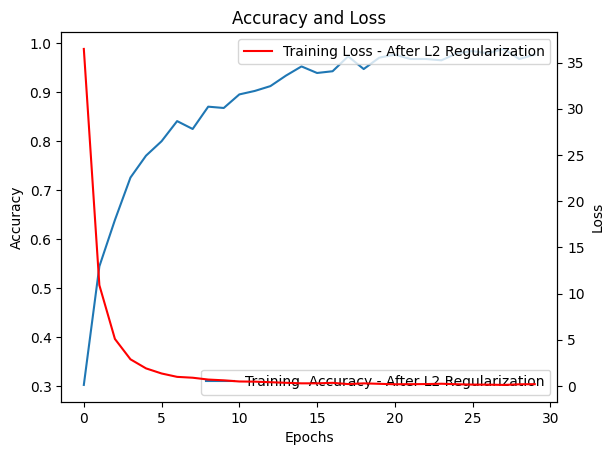

In [ ]:
plt.plot(model_regularized.history.history['accuracy'], label='Training  Accuracy - After L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and Loss')
plt.legend()

plt.twinx()
plt.plot(model_regularized.history.history['loss'], color='r', label='Training Loss - After L2 Regularization')
plt.ylabel('Loss')
plt.legend()

plt.show()

- As you can see, fluctuation disappered(or lowered). We saw fluctuation at Alexnet from scratch results. But after L2 regularization, it disappears. And we get better results than normal Alexnet from scratch.

# One of best Practices for Alexnet from scratch: Hyperparameter Optimization
Hyperparameters have major impacts on accuracy and efficiency while training the model. Therefore it needed to be set accurately to get better and efficient results. One of the method is **Grid search**, the other one is **Random Search**.

- **Grid Search:** In Grid Search, the possible values of hyperparameters are defined into the set. Then these sets of possible values of hyperparameters are combined by using Cartesian product and form a multidimensional grid. Then we try all the parameters in the grid and select the hyperparameter setting with the best result.

- **Random Search:** This is another variant of Grid Search in which instead of trying all the points in the grid we try random points. This solves the couple of problems that are in Grid Search such as we don’t need to expand our search space exponentially every time adding new hyperparameter.

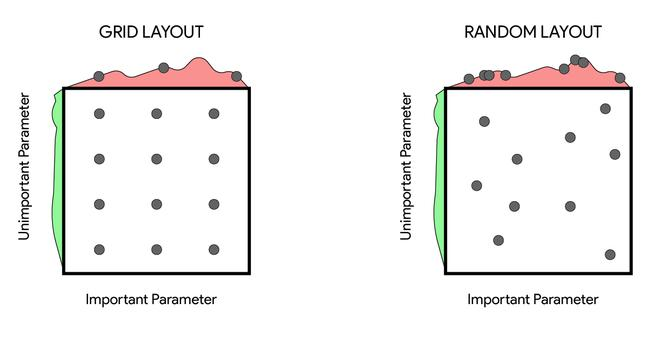

- We can miss important features with Grid Search.